<a id="top"></a>
# Vegetation Change <img align="right" style="padding:10px" src="../images/odc_logo.png">

This notebook uses changes in the Normalized Difference Vegetation Index (NDVI) to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral index in each of those time periods. Significant changes in NDVI (vegetation greenness) are coincident with land change, as long as the comparisons are done between similar time periods (seasons or years). Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. It is expected that this algorithm can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments. In some cases the impacts may be negative (deforestation, mining, burning, drought) or positive (regrowth, improved soil moisture). 

It should also be noted that the selection of the baseline and analysis time period is critical. First, the two time periods should be similar (season, year) so that the vegetation state can be compared in similar weather conditions. Second, the time periods should be sufficient clear (non-cloudy) data. If the baseline or analysis mosaic (composite of images) is contaminated with clouds, it will impact the results.

What does this Notebook do?
* [Setup the Environment](#environment_setup)
* [Choose Platforms and Products](#platforms_products)
* [Define Anlaysis Parameters](#define_analysis_params)
* [Load the Dataset and the Required Spectral Bands or Other Parameters](#load_data)
* [Create a Mosaic for the Baseline and Analysis Time Periods](#create_mosaic)
* [Calculate Anomaly Product](#anomalies)
* [Show Baseline RGB, Analysis RGB and Anomaly Products](#plots)
* [Calculate Pixel Counts within Thresholds](#calculate_pixels)

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Import Standard Python Modules
import datacube
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn
import xarray as xr
import numpy as np

In [24]:
# Add utils to the sys.path so that data_cube_utilities can be found. (Local folder hack.)
import sys
sys.path.append('../DCAL_utils')

# Import Data Cube API.
import data_access_api as dc_api

# Import display map functions
from dc_display_map import display_map

# Import clean mask function
from clean_mask import landsat_qa_clean_mask

# Import create mosaic functions
from dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic

# Import RGB function
from dc_rgb import rgb

In [4]:
# Initialize Data Cube (dc) and Data Cube API (api).
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

<a id="platforms_products"></a>
## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.

[Back to Top](#top)

In [5]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal
# Landsat-8 data is much better than Landsat-7 due to issues with "banding"

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

In [6]:
# Print extents of the Data Cube so we know what data is available
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print(time_extents)
print(latitude_extents)
print(longitude_extents)

(numpy.datetime64('2013-04-13T10:10:55.000000000'), numpy.datetime64('2020-01-27T10:09:38.000000000'))
(3.7730589405966173, 11.318637832619382)
(-3.772789446011382, 1.8863273493593828)


<p style="color:red";><b>Select Spatial Extents:</b> Select the area of interest (AOI) based on extents available.</p>

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 

# Mau Forest - Western Kenya
# Baseline = 5/30/2013, Analysis = 5/25/2017
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Mining Region near Obuasi, Ghana (small region)
# Baseline = 12/23/13, Analysis = 1/6/19
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

In [9]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  
* **Time Period:** Define analysis time period.
* **Mosaic Function:** Select mosaic functions to use.

[Back to Top](#top)

In [13]:
# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length (or more)
# or select a small window surrounding a clear single date (use Cloud Statistics notebook)
# Also, be sure to evaluate the RGB mosaics (below) to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = (datetime(2013,12,22), datetime(2013,12,24))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2019,1,5), datetime(2019,1,7))

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
# Use "median" for longer time periods, such as a year
# Use "most_recent_pixel" for short time periods, such as one day
# Use "max_ndvi" for seasonal time periods to compare vegetation peaks

baseline_mosaic_function = "most_recent_pixel" 
analysis_mosaic_function = "most_recent_pixel" 

<a id="load_data"></a>
## Load the Dataset and the Required Spectral Bands or Other Parameters [&#9652;](#top)
* **Load Data:** Load baseline and analysis data based on selections above.
* **Create Cloud Mask:** Cloud mask for the baseline and analysis datasets.

[Back to Top](#top)

In [14]:
# Load baseline dataset
baseline_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=baseline_time_period) 

In [15]:
# Load analysis dataset
analysis_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=analysis_time_period) 

In [16]:
# Compute and add cloud masks for baseline and anlaysis datasets.
cloud_mask_baseline = landsat_qa_clean_mask(baseline_ds, platform=platform)
baseline_ds = baseline_ds.where(cloud_mask_baseline)

cloud_mask_analysis = landsat_qa_clean_mask(analysis_ds, platform=platform)
analysis_ds = analysis_ds.where(cloud_mask_analysis)

<a id="create_mosaic"></a>
## Create a Mosaic for the Baseline and Analysis Time Periods [&#9652;](#top)

* **Create Mosaics:** Create baseline and analysis mosaics.

[Back to Top](#top)

In [18]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [19]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [20]:
baseline_composite = baseline_compositor(baseline_ds, cloud_mask_baseline.values)
analysis_composite = analysis_compositor(analysis_ds, cloud_mask_analysis.values)

<a id="anomalies"></a>
## Calculate Anomaly Product [&#9652;](#top)
* **Anomoly Product:** Compute anomaly product based on baseline and analysis composites.

[Back to Top](#top)

In [21]:
# Define NDVI function
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [22]:
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

<a id="plots"></a>
## Show Baseline RGB, Analysis RGB and Anomaly Products [&#9652;](#top)

* **Plot Settings:** Color scheme, loss and gain ranges.
* **Generate Plots:** RGB plot baseline, analysis, and anomaly products.

[Back to Top](#top)

In [26]:
# Set matplotlib colour scheme
RdYlGn.set_bad('black',1.)

In [27]:
# Define the significant anomaly range for Plot #4
loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2

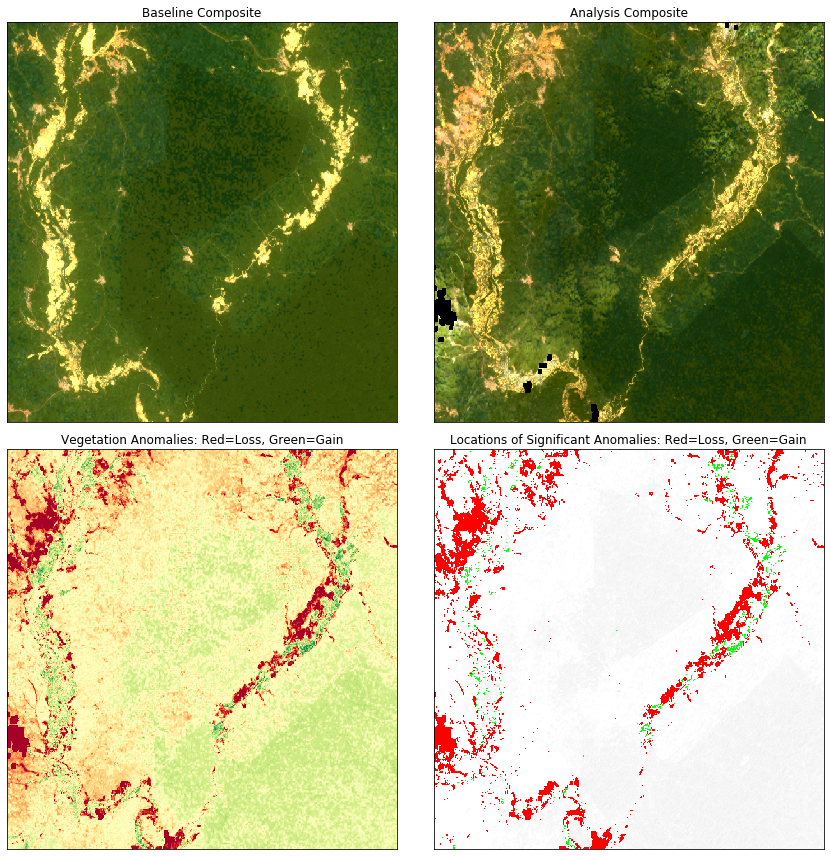

In [28]:
# Create plots of baseline, analysis, and anomaly products
fig, ax = plt.subplots(2, 2, figsize=(12,12))

for sub_ax in ax.flatten():
    sub_ax.set_facecolor('black')

baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values,analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values,analysis_rgb.quantile(up_qtl).values)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold
# NOTE: Clouds in either the baseline or analysis images will be removed from the anomaly product

## Plot #1 = Baseline RGB (upper left)
axes_image = baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_composite[plt4_bkg_band].where(cloud_mask_baseline.squeeze('time'))\
                     .values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Significant anomaly color overlays
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_composite.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr,name='rgb',dims=['rgb'],coords={'rgb': rgb_coord_arr})
plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, coords=plt4_coords,dims=list(analysis_composite.dims) + ['rgb'])
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

<a id="calculate_pixels"></a>
## Calculate Pixel Counts within Thresholds [&#9652;](#top)

* **Define Functions:** Define threshold count and percentage functions
* **Change Parameters:** Set change parameters.
* **Calculate and Output:** Calculate and output counts.

[Back to Top](#top)

In [30]:
# Define threshold count and percentage functions
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [31]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)
# This code block can be used for either vegetation loss or vegetation gain calculations

# NDVI losses might use the following limits: min=-1.0 and max=-0.2
# NDVI gains might use the following limits: min=0.2, max=1.0

minimum_change = -0.7
maximum_change = -0.2

In [32]:
# This output is a count of the pixels that fall within each threshold range
threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 436460,
 'total_non_cloudy': 436460,
 'inside': 28176,
 'outside': 408284}

In [33]:
# This output is a percentage of the pixels that fall within each threshold range
threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 6.455574393987994,
 'percent_outside_threshold': 93.544425606012,
 'percent_clouds': 0.0}